In [1]:
import numpy as np
from pysr import PySRRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
from sympy import pretty

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [4]:
def r2_calc(y, y_pred):
    r2 =r2_score(y, y_pred)
    print("R2 score: ", r2)
    return r2, y, y_pred

def mse_calc(y, y_pred):
    mse = mean_squared_error(y, y_pred)
    print("Mean Squared Error: ", mse)
    return mse

def error_percentage(y, y_pred):
    error = np.mean(np.abs((y - y_pred) / y)) * 100
    print("Mean Absolute Percentage Error: ", error)
    return error

# detect outliers using 3 standard deviation
def detect_outliers(data, threshold=3):
    mean = np.mean(data['delta_phi'])
    std_dev = np.std(data['delta_phi'])
    outliers = []
    for i in data['delta_phi']:
        z_score = (i - mean) / std_dev
        if np.abs(z_score) > threshold:
            outliers.append(i)
    data_without_outliers = data[~data['delta_phi'].isin(outliers)]
    return data_without_outliers


In [2]:
argon = pd.read_csv('data/real_ufrac_argon.csv')
water = pd.read_csv('data/real_ufrac_water.csv')
methane = pd.read_csv('data/real_ufrac_methane.csv')
total_data_onehot = pd.read_csv('data/real_ufrac_total_data_onehot.csv')
# drop Unnamed: 0 column
argon = argon.drop(columns=['Unnamed: 0'])
water = water.drop(columns=['Unnamed: 0'])
methane = methane.drop(columns=['Unnamed: 0'])

In [3]:
argon

,temperature,density,real_ufrac,delta_phi,stable
0,120,0.001000,-0.277879,-0.277879,0
1,120,80.161319,-0.274136,-0.276884,0
2,120,160.321637,-0.270407,-0.275920,0
3,120,240.481956,-0.266693,-0.274988,0
4,120,320.642275,-0.262993,-0.274087,0
...,...,...,...,...,...
15165,440,39679.358725,-0.255361,-1.253429,0
15166,440,39759.519044,-0.260303,-1.258414,0
15167,440,39839.679363,-0.265284,-1.263437,0
15168,440,39919.839681,-0.270305,-1.268500,0


In [5]:
water_without_outliers = detect_outliers(water)
len_water = len(water)
len_water_without_outliers = len(water_without_outliers)
print("Number of outliers in water data: ", len_water - len_water_without_outliers)

Number of outliers in water data:  3


In [6]:
def argon_sample(argon, sample_frac):
    argon_sample = pd.DataFrame({})
    Temperatures = argon['temperature'].unique()
    for T in Temperatures:
        if T < 200:
            data = argon[argon['temperature'] == T]
            argon_sample = pd.concat([argon_sample, data])
        if T>=200:
            data = argon[argon['temperature'] == T].sample(frac = sample_frac)
            argon_sample = pd.concat([argon_sample, data])
    print("length of original argon data: ", len(argon), "length of sampled argon data: ", len(argon_sample))
    return argon_sample

total_data_onehot = pd.DataFrame()
data = [argon, water, methane]
label = ['argon', 'water', 'methane']
for i in range(3):
    data[i][label[i]] = 1
    for other_label in label:
        if other_label != label[i]:
            data[i][other_label] = 0
    if i == 0:
        data[i] = argon_sample(data[i], 0.8)
    if i == 2:
        data[i] = argon_sample(data[i], 0.8)
    # concatenate temperature, density, delta_phi, argon, water, methane columns, don't need to concatenate other columns
    total_data_onehot = pd.concat([total_data_onehot, data[i]], axis=0)
print("length of total data: ", len(total_data_onehot))
    

length of original argon data:  15170 length of sampled argon data:  12670
length of original argon data:  9957 length of sampled argon data:  8157
length of total data:  21489


In [7]:
total_data_onehot.to_csv('data/real_ufrac_total_data_onehot.csv', index=False)

In [5]:
substance = 'argon'
data_p = argon
model = PySRRegressor.from_file(f'result/pySR_{substance}_1.pkl')
#model = PySRRegressor.from_file('hall_of_fame_2024-10-09_205803.860.pkl')

Checking if result/pySR_argon_1.pkl exists...
Loading model from result/pySR_argon_1.pkl


In [6]:
#X = data_p.iloc[:, 1:3]
X = data_p[['temperature', 'density']]
y = data_p['delta_phi']
y_pred = model.predict(X)
r2 = r2_calc(y, y_pred)
mse = mse_calc(y, y_pred)
mape = error_percentage(y, y_pred)


R2 score:  0.9796458402030929
Mean Squared Error:  0.0010782630693033687
Mean Absolute Percentage Error:  18.205755215805652


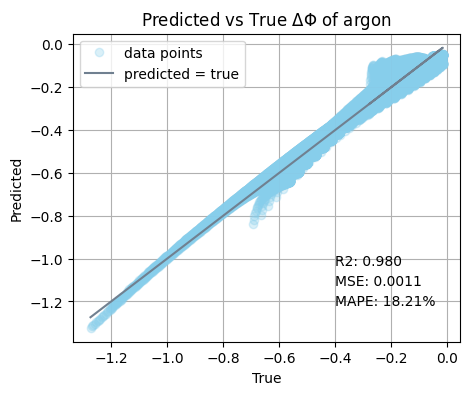

In [7]:
fig = plt.figure(figsize=(5,4))
plt.plot(y, y_pred, 'o',label='data points',color='skyblue', alpha=0.3)
plt.plot(y, y, 'slategrey', label='predicted = true')
plt.text(0.65, 0.3, f'R2: {r2_score(y, y_pred):.3f}', transform=fig.transFigure)
plt.text(0.65, 0.25, f'MSE: {mean_squared_error(y, y_pred):.4f}', transform=fig.transFigure)
plt.text(0.65, 0.20, f'MAPE: {np.mean(np.abs((y - y_pred) / y)) * 100:.2f}%', transform=fig.transFigure)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.legend()
#plt.ylim(-2,2)
#plt.xlim(-2,2)
plt.title(f"Predicted vs True $\\Delta \\Phi$ of {substance}")
plt.grid()
plt.show()

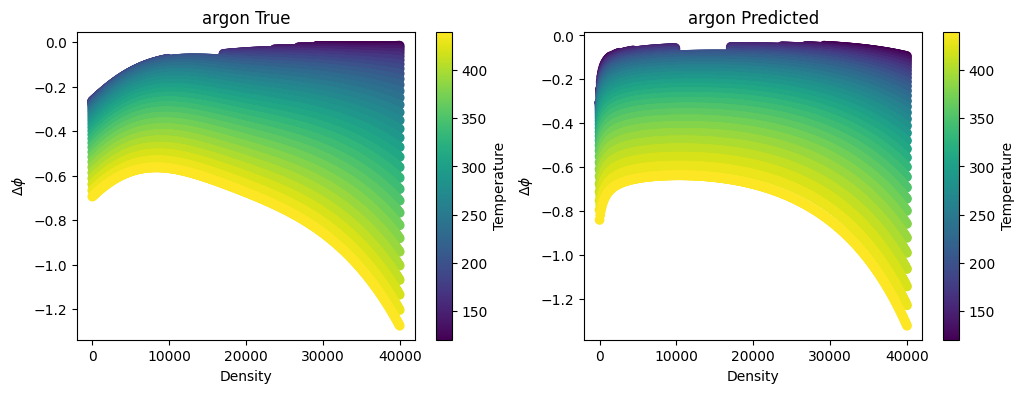

In [11]:
fig = plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
scatter = plt.scatter(data_p['density'], data_p['delta_phi'], c=data_p['temperature'], cmap='viridis')
color_bar = plt.colorbar(scatter)
color_bar.set_label('Temperature')
plt.xlabel('Density')
#plt.ylim(-2,0)
plt.ylabel('$\\Delta \\phi$')
# plot phi = -0.4
#plt.axhline(y=-0.27, color='r', linestyle='--')
#plt.axhline(y=0, color='r', linestyle='--')
plt.title(f'{substance} True')
plt.subplot(1,2,2)
scatter = plt.scatter(data_p['density'], y_pred, c=data_p['temperature'], cmap='viridis')
color_bar = plt.colorbar(scatter)
color_bar.set_label('Temperature')
plt.xlabel('Density')
plt.ylabel('$\\Delta \\phi$')
plt.title(f'{substance} Predicted')
#plt.ylim(-2,0)
#plt.axhline(y=-0.45, color='r', linestyle='--')
#plt.axhline(y=0, color='r', linestyle='--')
plt.show()

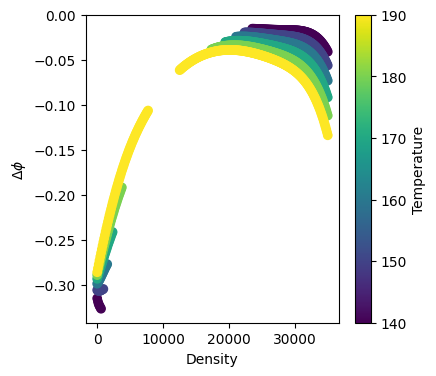

In [12]:
data_pl = methane[(methane['temperature']>=0) & (methane['temperature']<=190)]
fig = plt.figure(figsize=(9, 4))
plt.subplot(1,2,1)
scatter = plt.scatter(data_pl['density'], data_pl['delta_phi'], c=data_pl['temperature'], cmap='viridis')
color_bar = plt.colorbar(scatter)
color_bar.set_label('Temperature')
plt.xlabel('Density')
#plt.xlim(-5000,60000)
#plt.ylim(-3, 7)
plt.ylabel('$\\Delta \\phi$')
plt.show()

In [13]:
best_model = model.get_best()
print(best_model)


complexity                                                                                                                                                                            26
loss                                                                                                                                                                            0.001073
score                                                                                                                                                                           0.526697
equation         sinh(cube(-0.0021464918 * ((temperature - cube(exp(log(density)) * cube(-0.04926871))) / 1.1533699)) - sin(sin(sqrt(sqrt(temperature)) / sqrt(temperature + density))))
sympy_format                                    sinh(6.44587473488389e-9*(-1.71056949085494e-12*density**3 - temperature)**3 - sin(sin(temperature**(1/4)/sqrt(density + temperature))))
lambda_format                  PySRFunction(X=>sinh(6.44587473488389e-9*(-1

In [14]:
X = total_data_onehot[['temperature', 'density', 'argon', 'water', 'methane']]
X 

,temperature,density,argon,water,methane
0,120,0.001000,1,0,0
1,120,80.161319,1,0,0
2,120,160.321637,1,0,0
3,120,240.481956,1,0,0
4,120,320.642275,1,0,0
...,...,...,...,...,...
21484,490,22709.030452,0,0,1
21485,490,18143.813191,0,0,1
21486,490,10066.890344,0,0,1
21487,490,10183.947197,0,0,1
